In [1]:
import json
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import simps
from scipy.signal import butter, filtfilt, iirnotch, spectrogram

In [2]:
def preprocessing(
    t: np.ndarray,
    y: np.ndarray,
    *,
    sfreq: int = 1000,
    t_baseline: float = None,
    c_baseline: bool = False,
    l_pass: int = None,
    h_band: int = None,
    l_band: int = None,
    notch: int = None,
):
    data = y.copy()
    interval = t.copy()

    # Baseline Correction
    if t_baseline is not None:
        baseline_idx = np.argwhere(t >= t_baseline)[0][0]
        baseline = data[:baseline_idx]
        y0 = np.mean(baseline)
    else:
        y0 = np.mean(data)

    data = data - y0

    # Crop Baseline
    if c_baseline:
        data = data[baseline_idx:]
        interval = interval[baseline_idx:]

    # Band-pass Filter
    if l_band is not None and h_band is not None:
        high = h_band / (sfreq / 2)
        low = l_band / (sfreq / 2)
        b, a = butter(4, [high, low], btype="bandpass")
        data = filtfilt(b, a, data)

    # Rectification
    data = np.abs(data)

    # Low-pass Filter
    if l_pass is not None:
        low = l_pass / (sfreq / 2)
        b, a = butter(4, low, btype="lowpass")
        data = filtfilt(b, a, data)

    # Notch Filter
    if notch in [50, 60]:
        b, a = iirnotch(notch, 30.0, sfreq)

    # Min-Max Normalization
    return interval, data  # (data - data.min()) / (data.max() - data.min())


def load_data(filepath: str, channel: int, show: bool = False):
    df = pd.read_csv(f"{filepath}.csv")
    values = df.to_numpy()
    time = values[:, 0]
    data = values[:, channel] * 3.3 / 65535

    with open(f"{filepath}_points.json", "r") as f:
        points = json.load(f)

    time, data = preprocessing(
        time,
        data,
        t_baseline=points["baseline"],
        c_baseline=True,
        l_pass=40,
        h_band=15,
        l_band=400,
        notch=50,
    )

    if show:
        plt.figure(figsize=(24, 6))
        plt.plot(time, data)

        periods = []
        c = ["r", "g"]
        for i in range(3):
            t0 = np.argwhere(time >= config[f"close_{i}"])[0][0]
            tf = np.argwhere(time >= config[f"open_{i}"])[0][0]
            periods.extend([t0, tf])
        periods.append(np.argwhere(time >= 21.9)[0][0])
        for i in range(len(periods) - 1):
            if i in [0, 1]:
                plt.axvspan(
                    time[periods[i]],
                    time[periods[i + 1]],
                    color=c[i % 2],
                    alpha=0.3,
                    label=f"{'Sitdown action' if i%2==0 else 'Stand up action'}",
                )
            else:
                plt.axvspan(
                    time[periods[i]],
                    time[periods[i + 1]],
                    color=c[i % 2],
                    alpha=0.3,
                )
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (voltes)")
        plt.legend()
        plt.grid(linewidth=1, linestyle="--", alpha=0.7)
        plt.show()
    return time, data

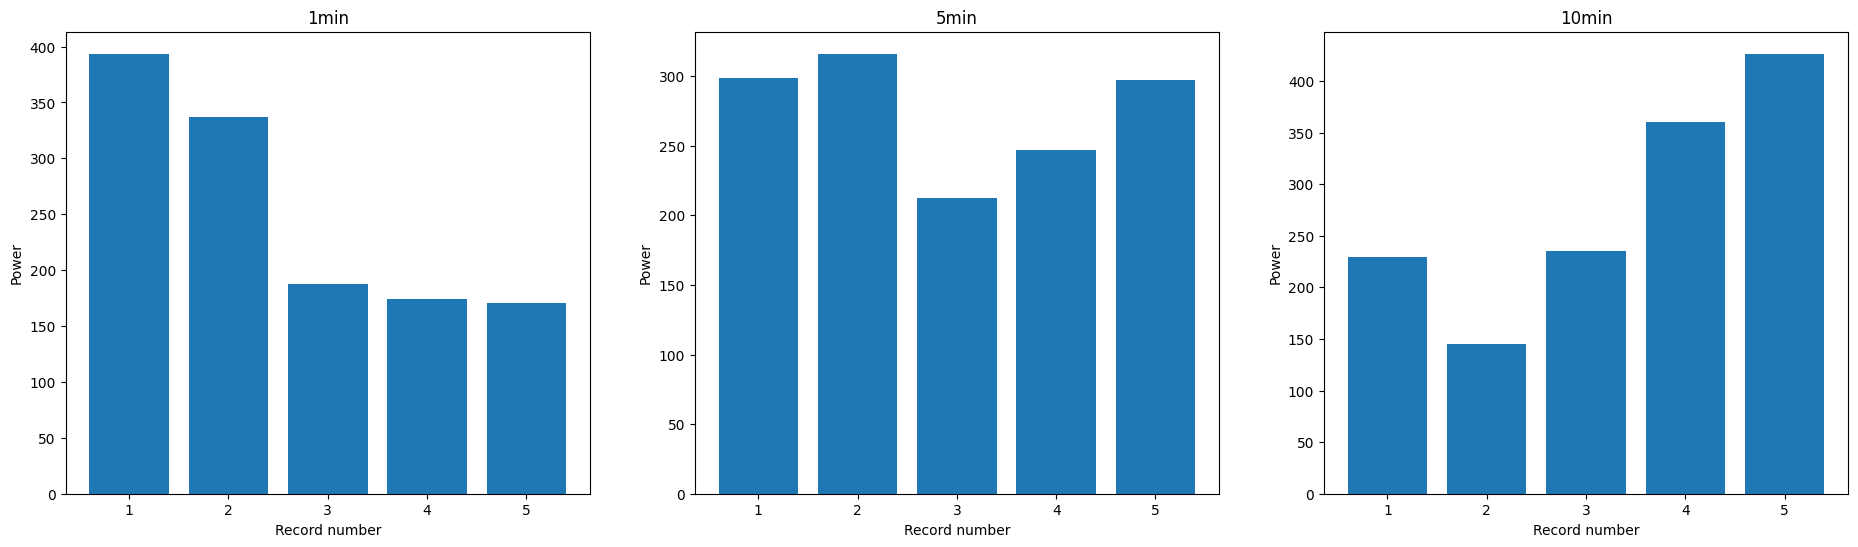

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(23, 6))

for k, cls in enumerate(["1min", "5min", "10min"]):
    powers = []
    exp = np.arange(5) + 1
    for i in exp:
        t, d = load_data(f"../data/rest_time/{cls}/exp_{i}", 1, False)
        powers.append(simps(np.power(d, 2)))

    axes[k].set_title(cls)
    axes[k].bar(exp, powers)
    axes[k].set_xlabel("Record number")
    axes[k].set_ylabel("Power")

plt.savefig("compare_powers_v1.png")

In [4]:
def data_prepare(
    filename: str,
    low_pass: int = 10,
    sfreq: int = 1000,
    high_band: int = 20,
    low_band: int = 450,
) -> Tuple[np.ndarray, np.ndarray, Dict]:
    # Read data and correction to 3.3v
    df = pd.read_csv(f"{filename}.csv")
    values = df.to_numpy()
    time = values[:, 0]
    data = values[:, 1:] * 3.3 / 65535

    with open(f"{filename}_points.json", "r") as f:
        points = json.load(f)

    # Remove basline mean
    baseline_idx = np.argwhere(time >= points["baseline"])[0][0]
    baseline = data[:baseline_idx, :]
    x0 = np.mean(baseline, axis=0)

    normalize = data - x0
    yf = np.argwhere(time >= 22)[0][0]

    time = time[baseline_idx:yf]
    data_removed_mean = normalize[baseline_idx:yf, :]

    # create bandpass filter for EMG
    high = high_band / (sfreq / 2)
    low = low_band / (sfreq / 2)
    b, a = butter(4, [high, low], btype="bandpass")
    data_filtered = np.vstack(
        [
            filtfilt(b, a, data_removed_mean[:, i])
            for i in range(data_removed_mean.shape[1])
        ]
    ).T

    # notch filter
    b_notch, a_notch = iirnotch(50.0, 30.0, sfreq)
    data_notched = np.vstack(
        [
            filtfilt(b_notch, a_notch, data_filtered[:, i])
            for i in range(data_filtered.shape[1])
        ]
    ).T

    # rectify emg signal
    data_rectified = abs(data_notched)

    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass / (sfreq / 2)
    b2, a2 = butter(4, low_pass, btype="lowpass")
    data_envelope = np.vstack(
        [filtfilt(b2, a2, data_rectified[:, i]) for i in range(data_rectified.shape[1])]
    ).T

    return time, data_envelope, points

In [5]:
def analyze_data(folderpath: str, count: int, channel: int, show: bool = False):
    rms = []
    total = []
    for exp in range(count):
        interval, emg, config = data_prepare(
            f"{folderpath}/exp_{exp+1}", low_pass=40, high_band=15, low_band=400
        )
        rms.append(np.sqrt(np.mean(np.power(emg[:, channel], 2))))
        total.append(simps(np.power(emg[:, channel], 2)))

        if show:
            fig, axes = plt.subplots(
                1, 2, figsize=(27, 6), gridspec_kw={"width_ratios": [3, 1]}
            )
            fig.suptitle(f"Experiment {exp + 1}; Power {total[-1]:.5f}")

            axes[0].plot(
                interval, emg[:, channel] * 1000, label=f"Experiment {exp + 1}"
            )

            axes[0].grid(True, linestyle="--", alpha=0.7)
            axes[0].set_xlabel("Time (seconds)")
            axes[0].set_ylabel("Signal (mV)")
            c = ["r", "g"]
            periods = []
            for i in range(3):
                t0 = np.argwhere(interval >= config[f"close_{i}"])[0][0]
                tf = np.argwhere(interval >= config[f"open_{i}"])[0][0]
                periods.extend([t0, tf])
            periods.append(np.argwhere(interval >= 21.9)[0][0])
            for i in range(len(periods) - 1):
                if i in [0, 1]:
                    axes[0].axvspan(
                        interval[periods[i]],
                        interval[periods[i + 1]],
                        color=c[i % 2],
                        alpha=0.3,
                        label=f"{'Sitdown action' if i%2==0 else 'Stand up action'}",
                    )
                else:
                    axes[0].axvspan(
                        interval[periods[i]],
                        interval[periods[i + 1]],
                        color=c[i % 2],
                        alpha=0.3,
                    )
            axes[0].legend()

            f, t, Sxx = spectrogram(
                emg[:, channel], emg.shape[0] / (interval[-1] - interval[periods[0]])
            )
            axes[1].pcolormesh(t + interval[periods[0]], f, Sxx, shading="gouraud")
            axes[1].set_ylabel("Frequency [Hz]")
            axes[1].set_xlabel("Time [sec]")
            axes[1].set_ylim([0, 30])

            plt.show()
    plt.bar(np.arange(count) + 1, rms, label="RMS")
    plt.legend()
    plt.show()

    plt.bar(np.arange(count) + 1, total, label="Simps")
    plt.legend()
    plt.show()

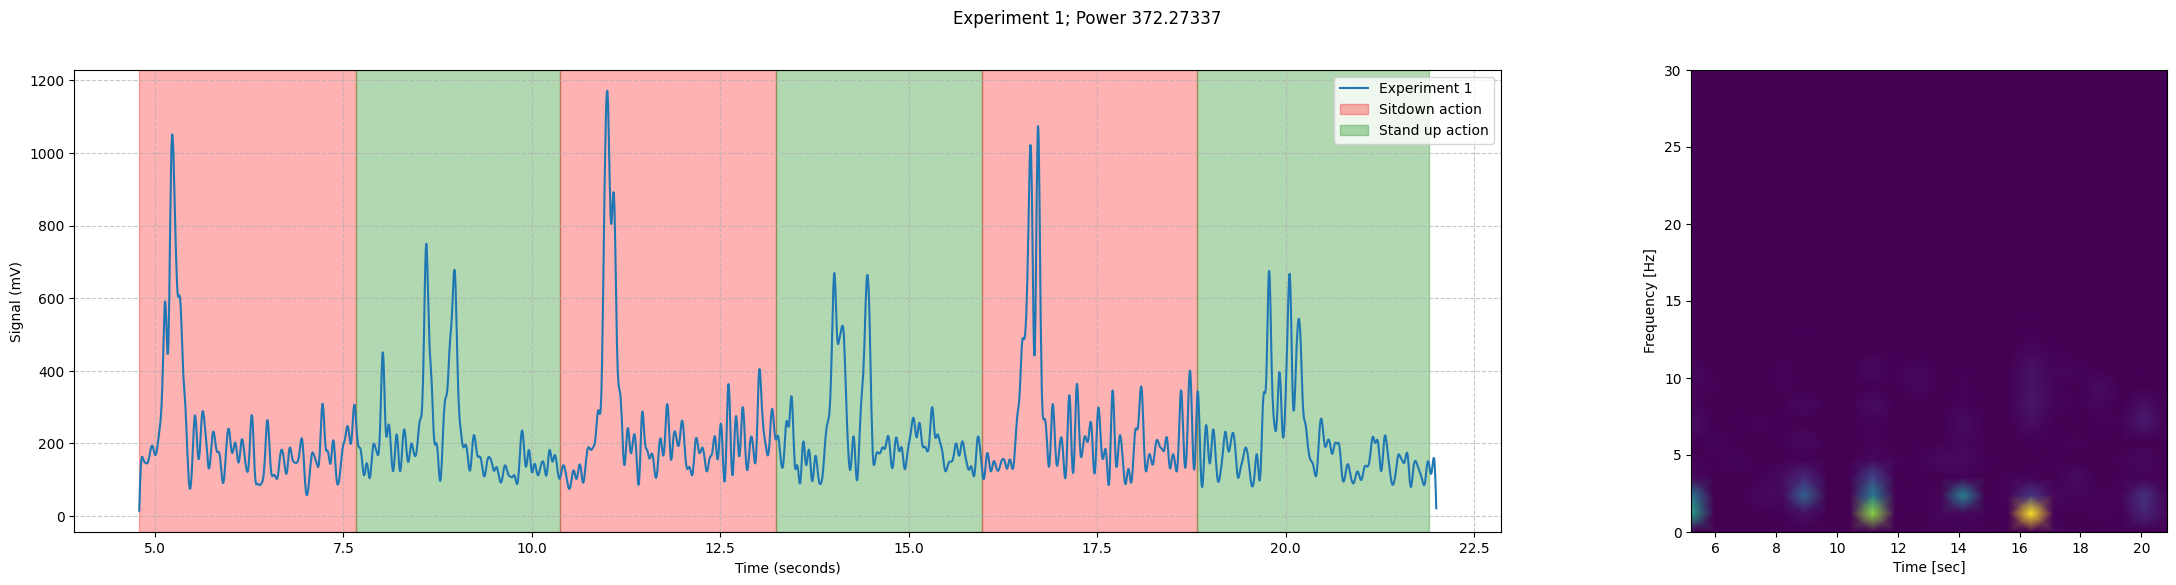

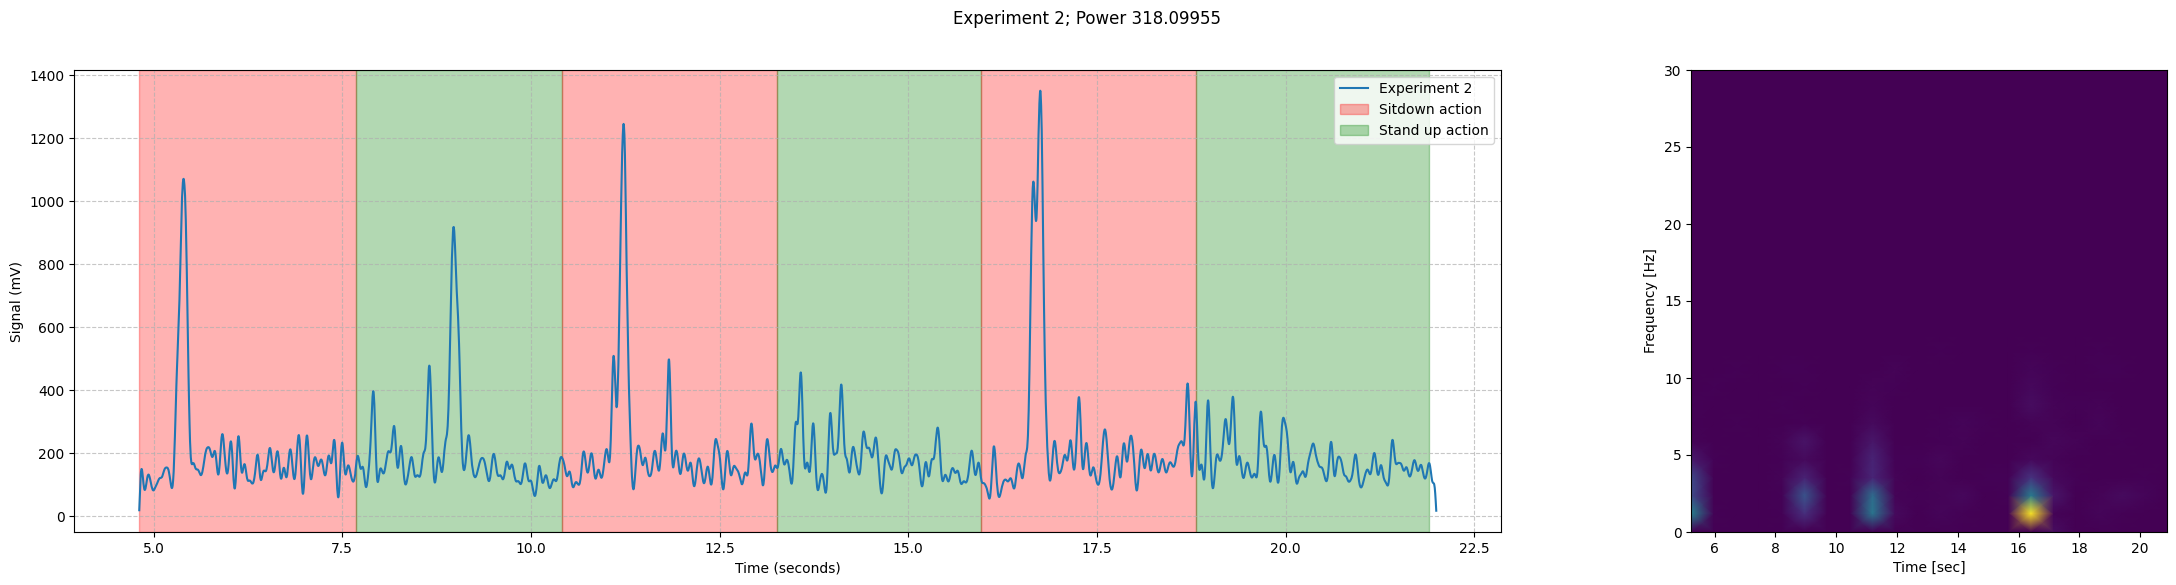

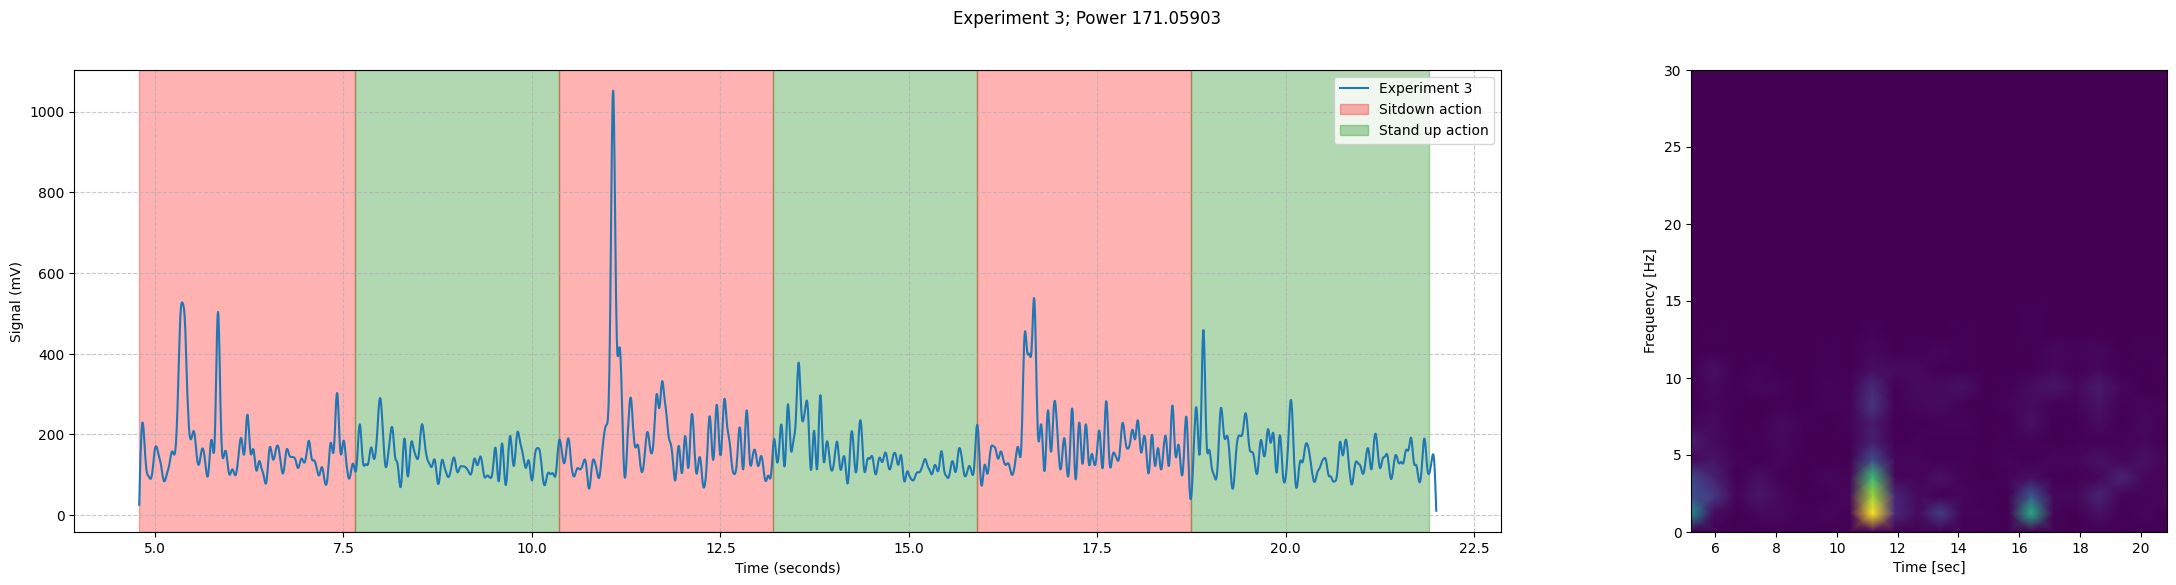

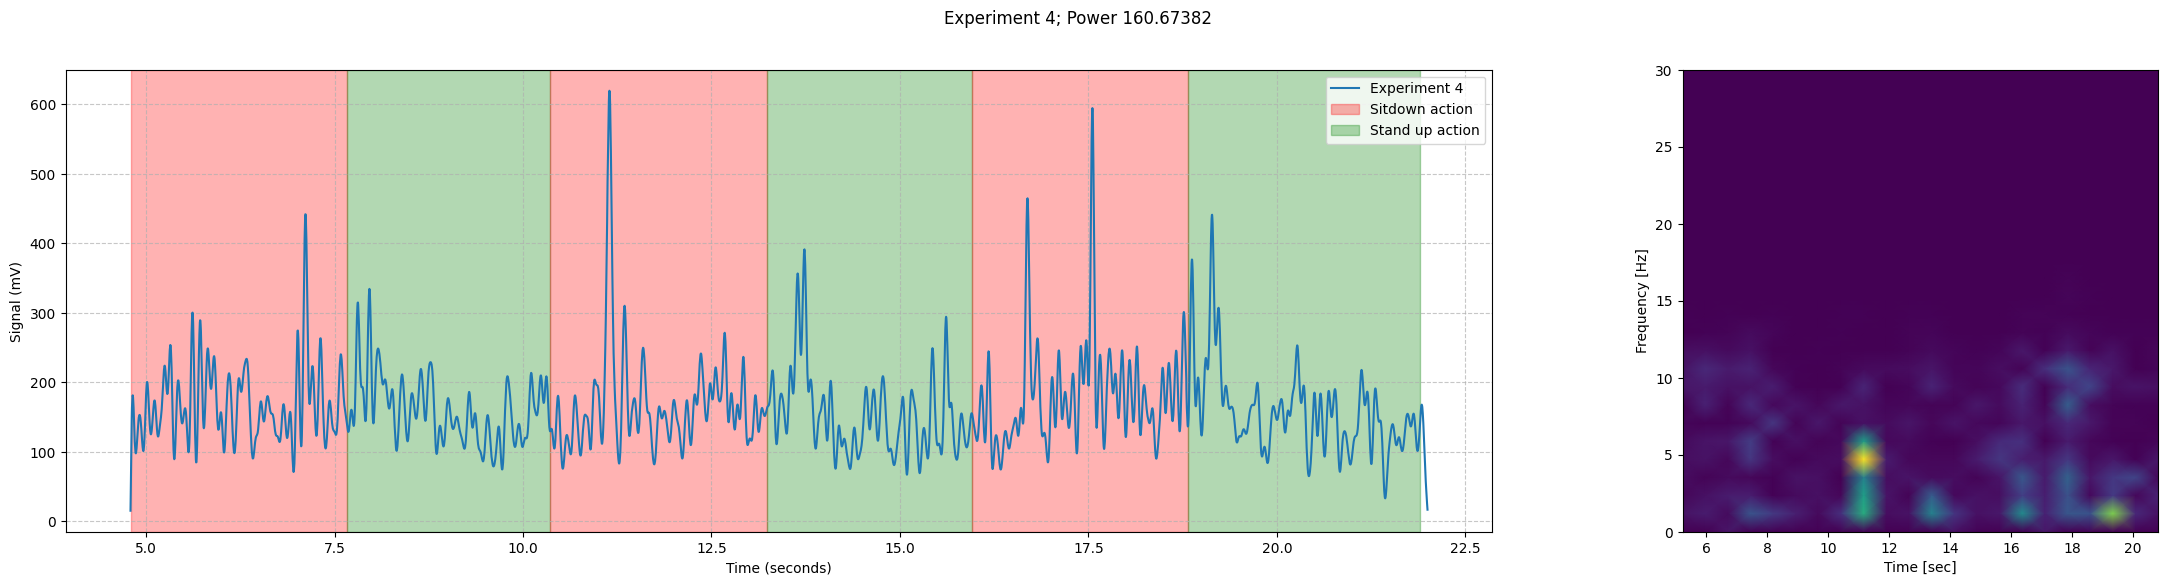

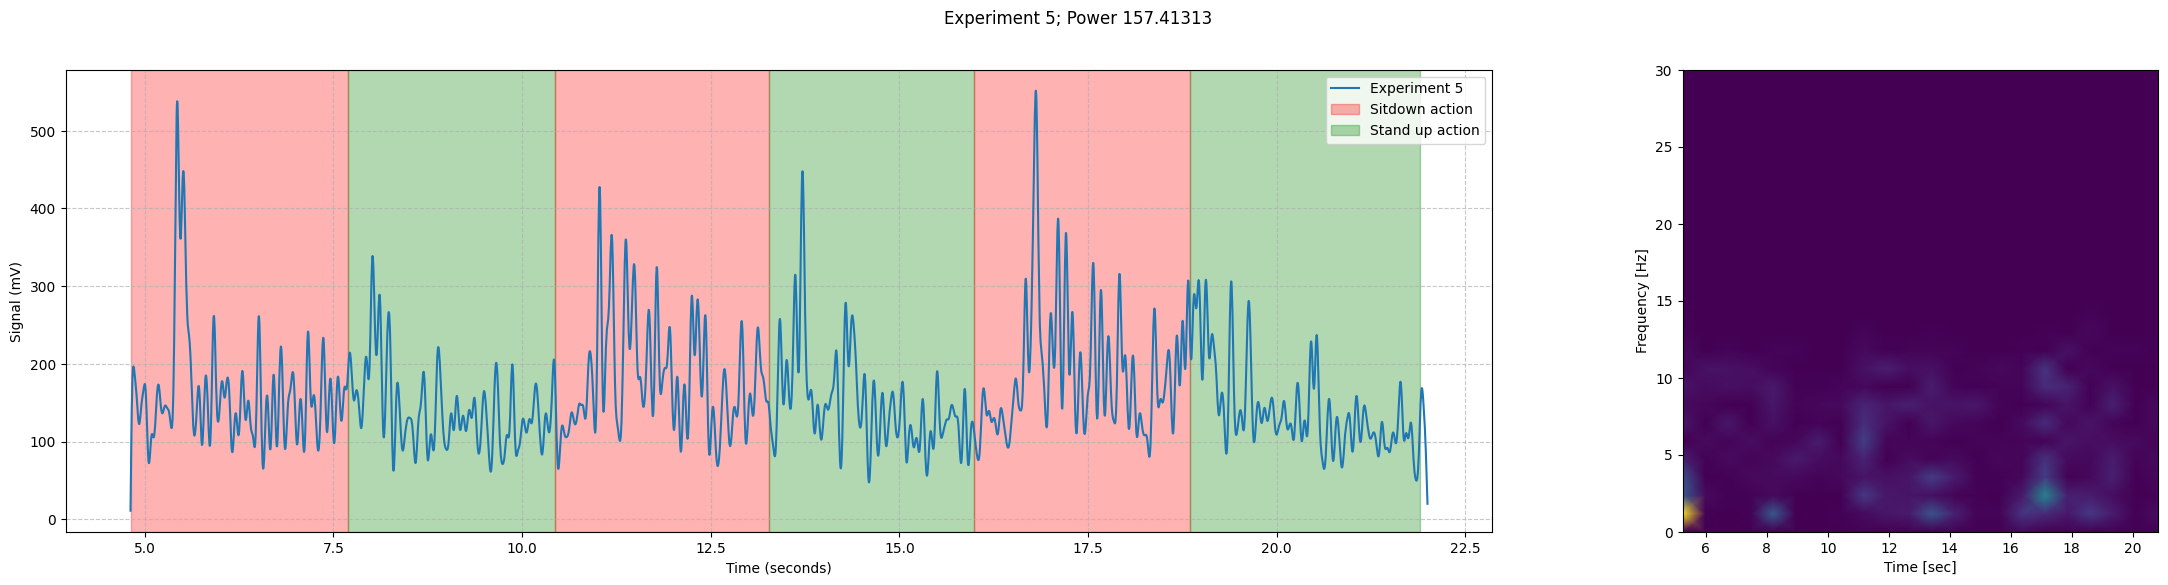

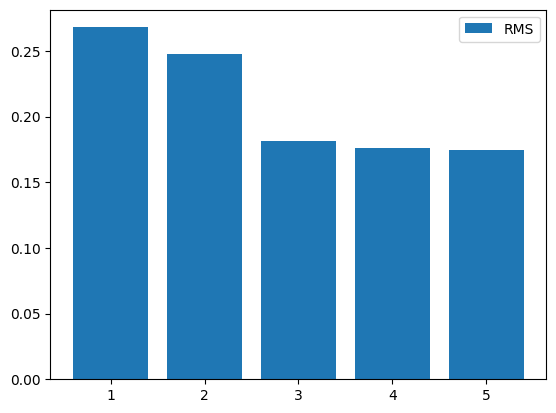

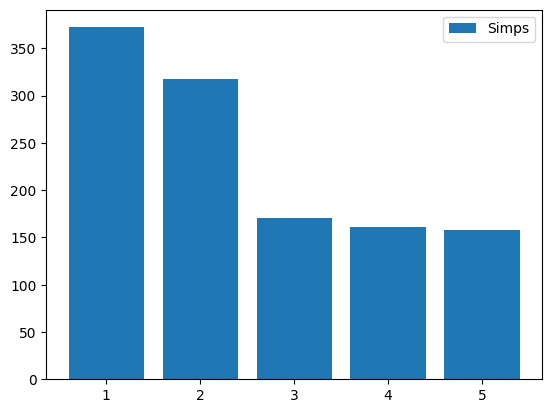

In [9]:
analyze_data("../data/rest_time/1min", 5, 0, show=True)

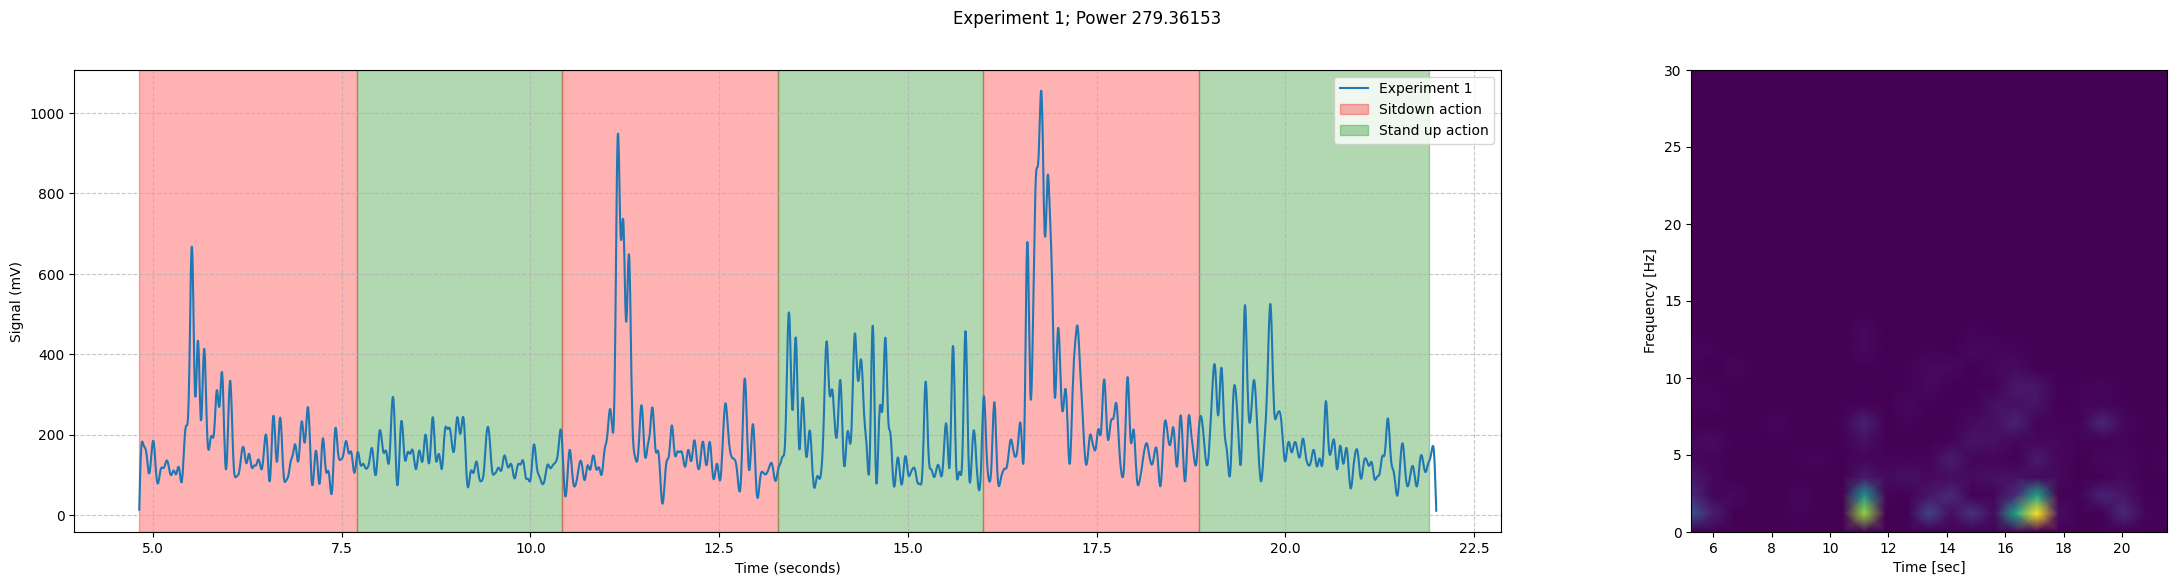

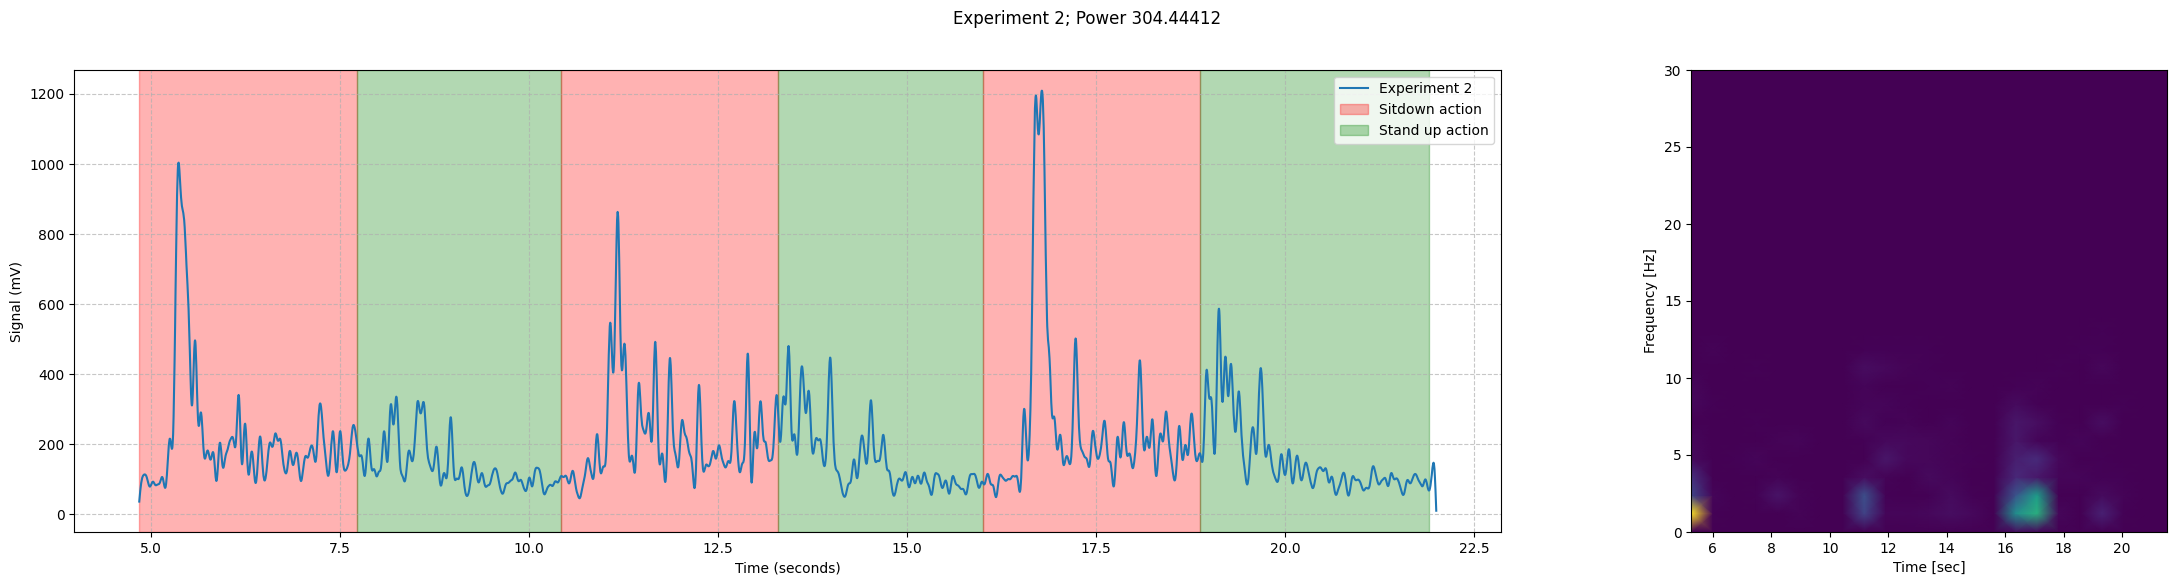

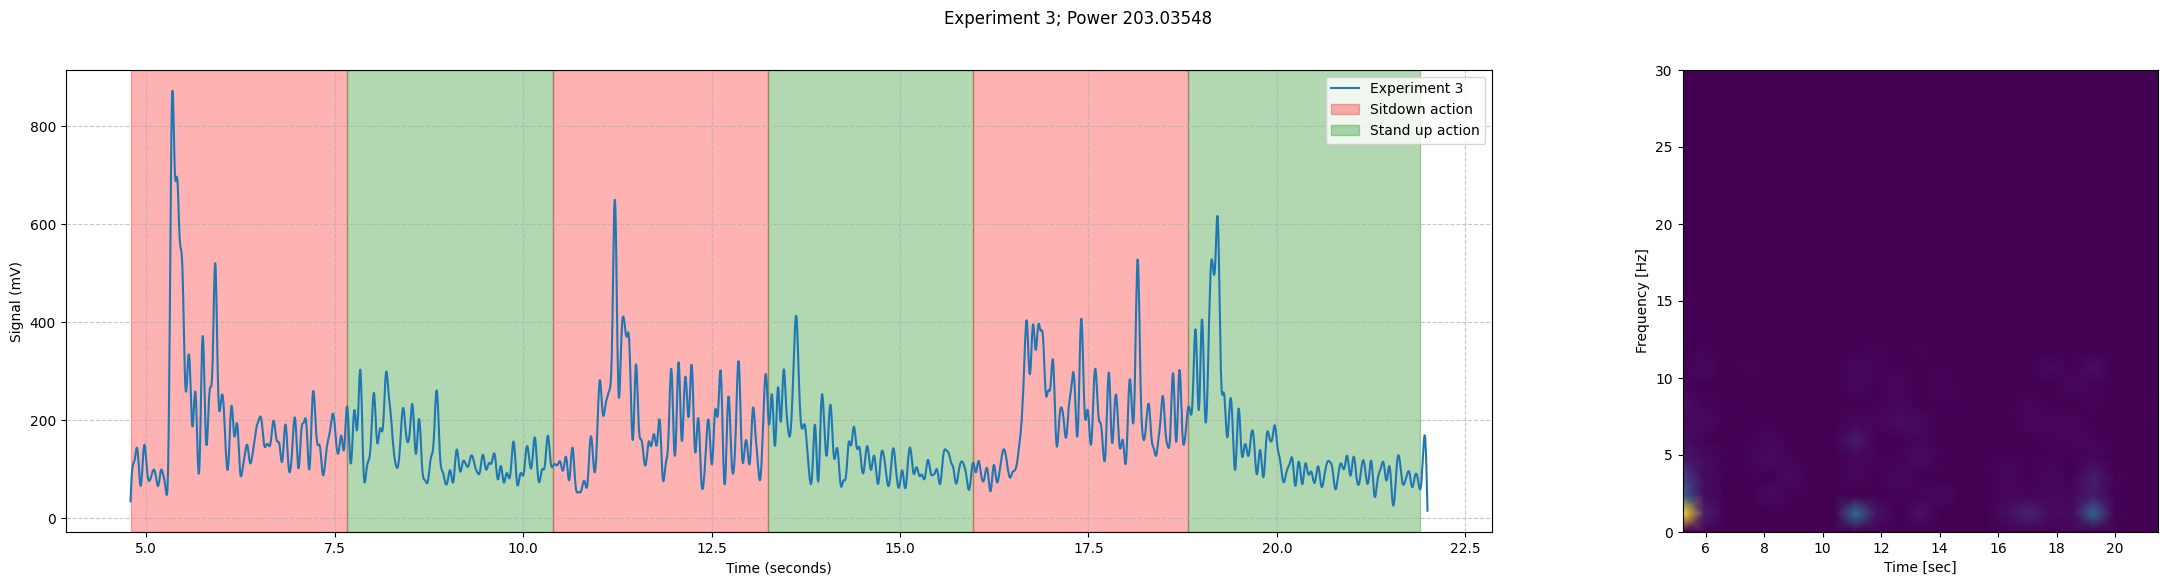

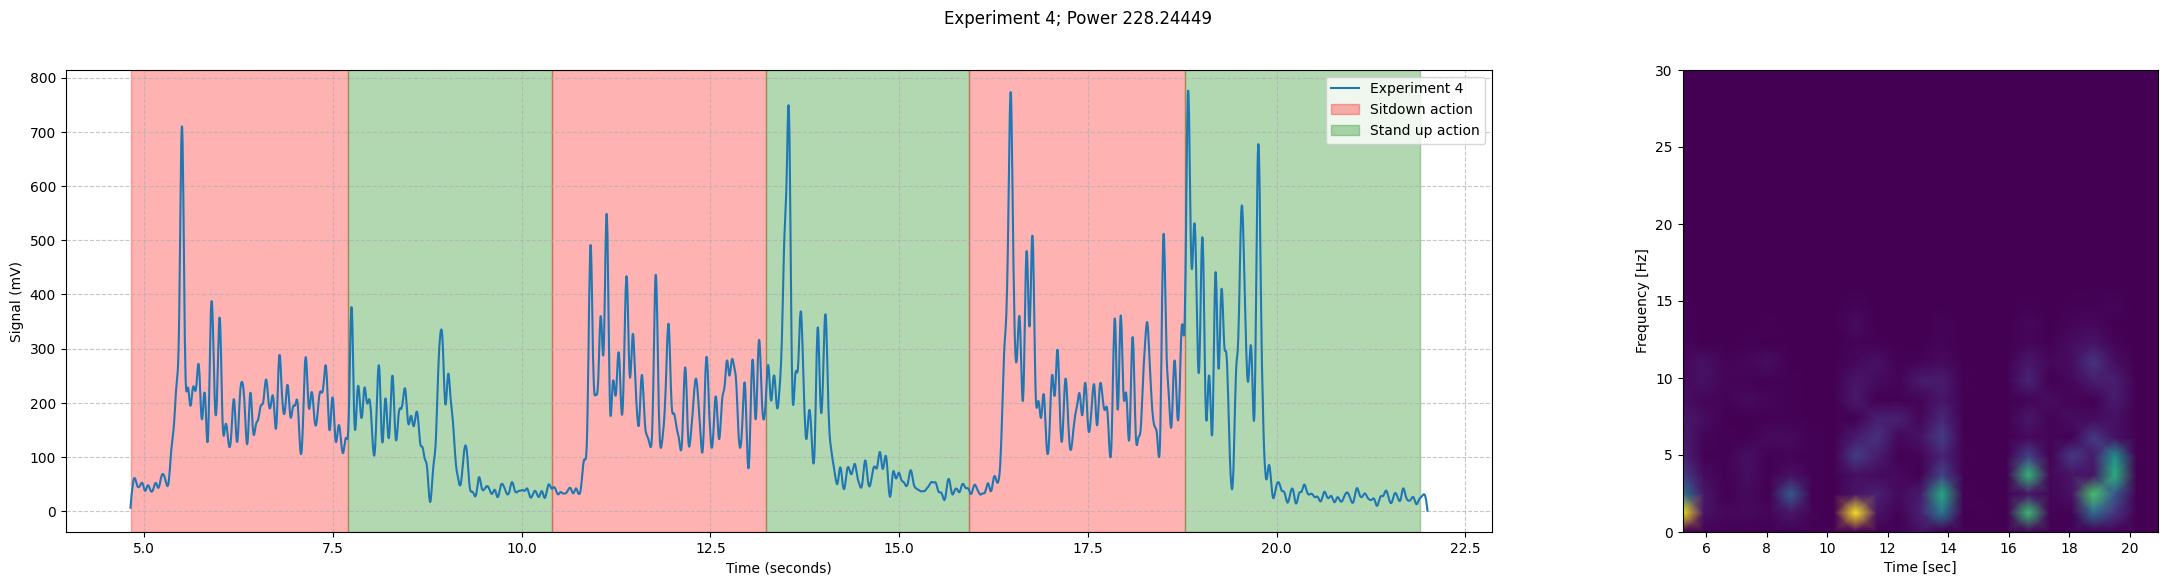

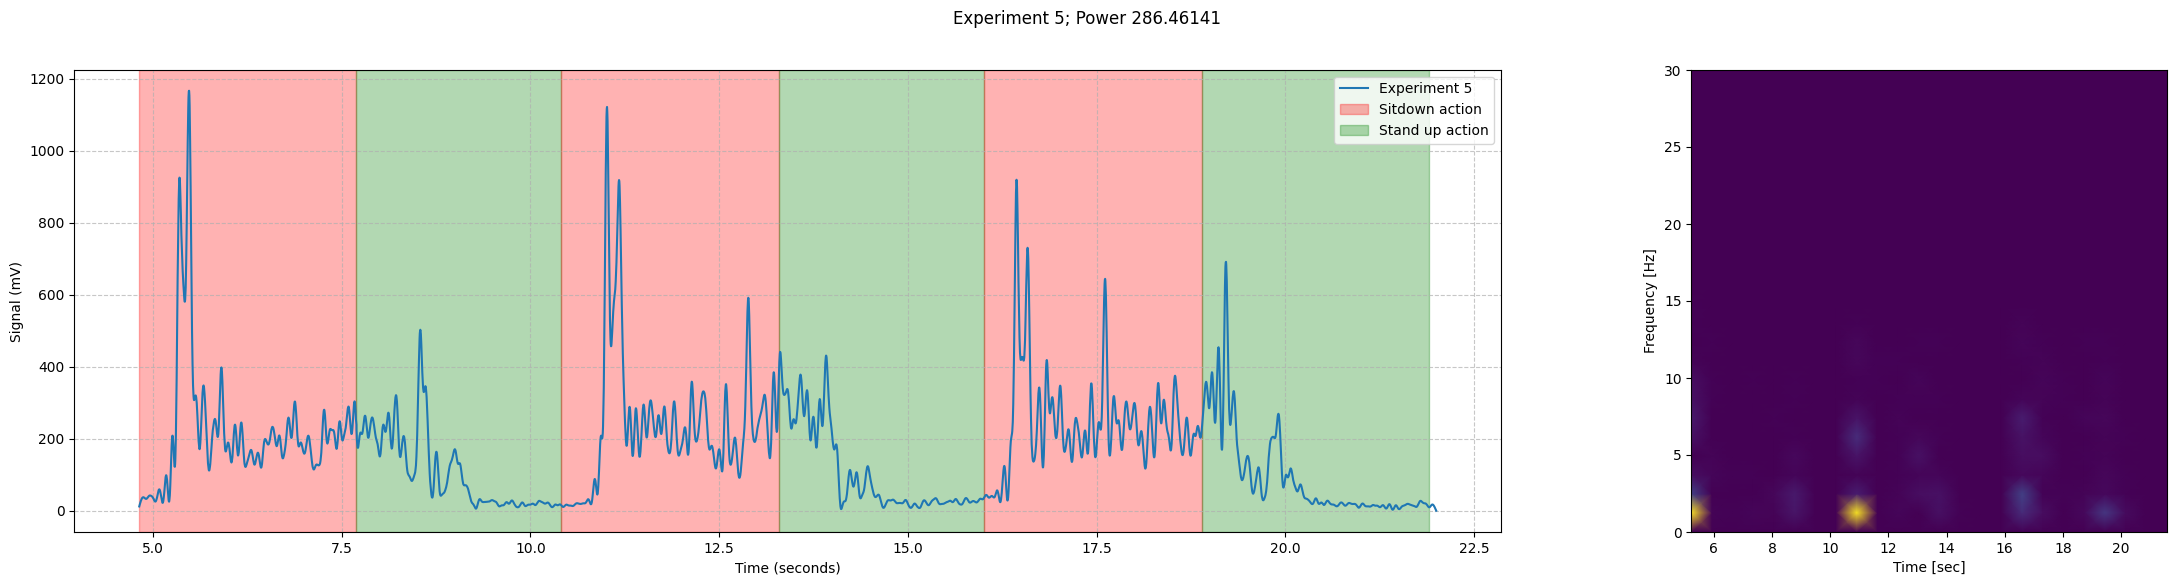

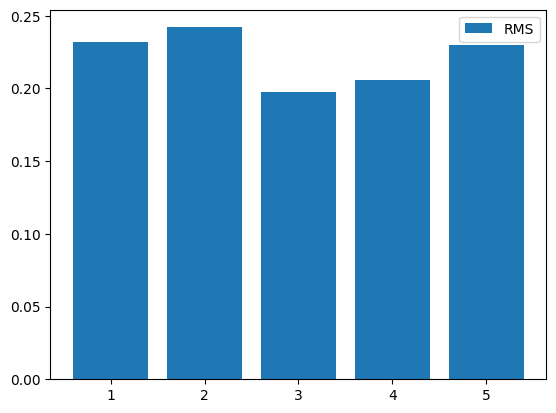

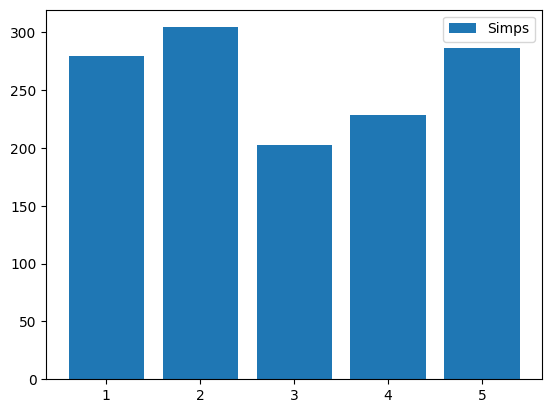

In [10]:
analyze_data("../data/rest_time/5min", 5, 0, show=True)

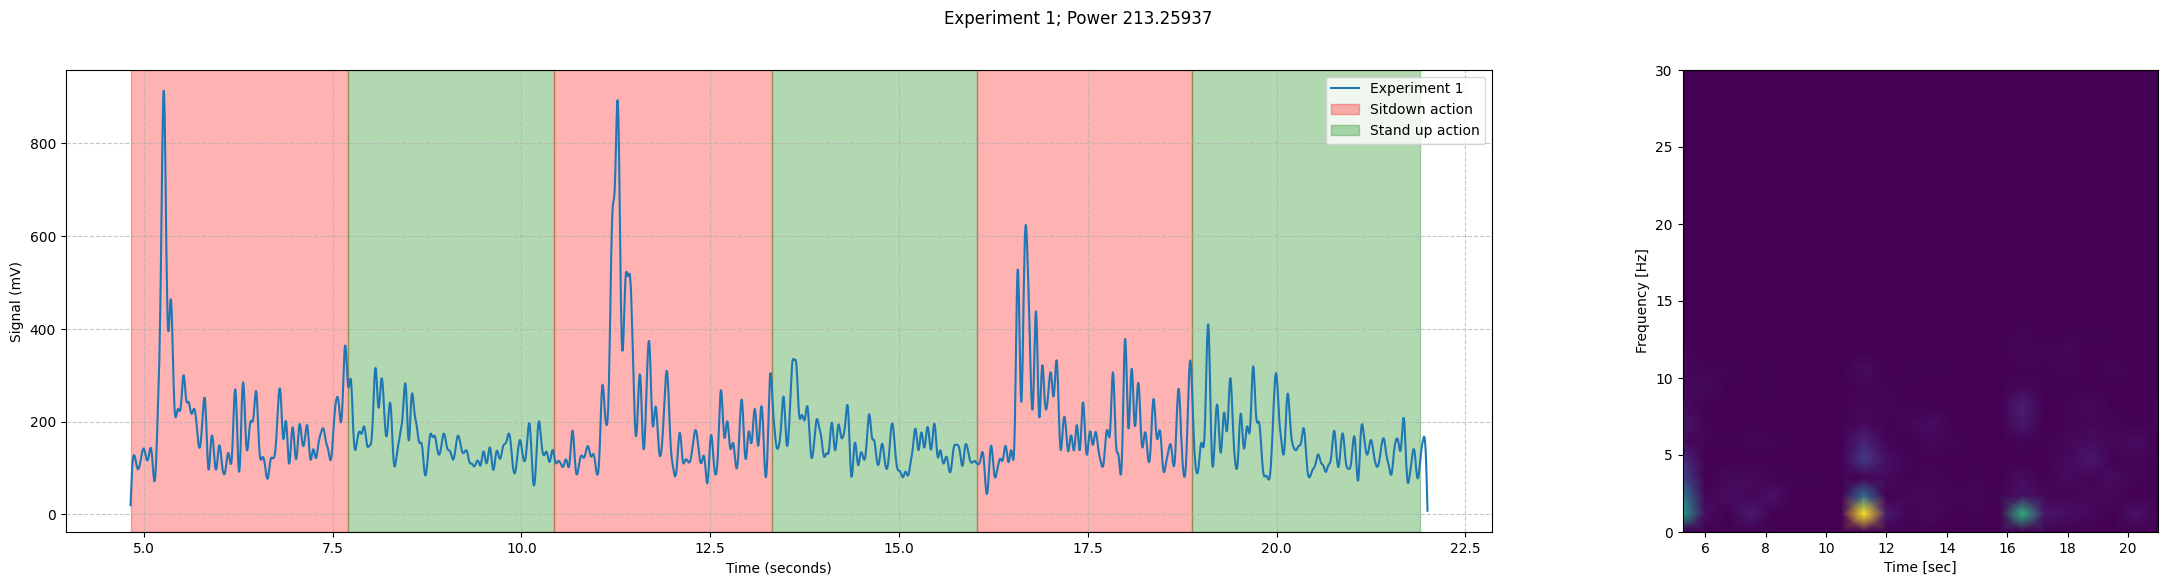

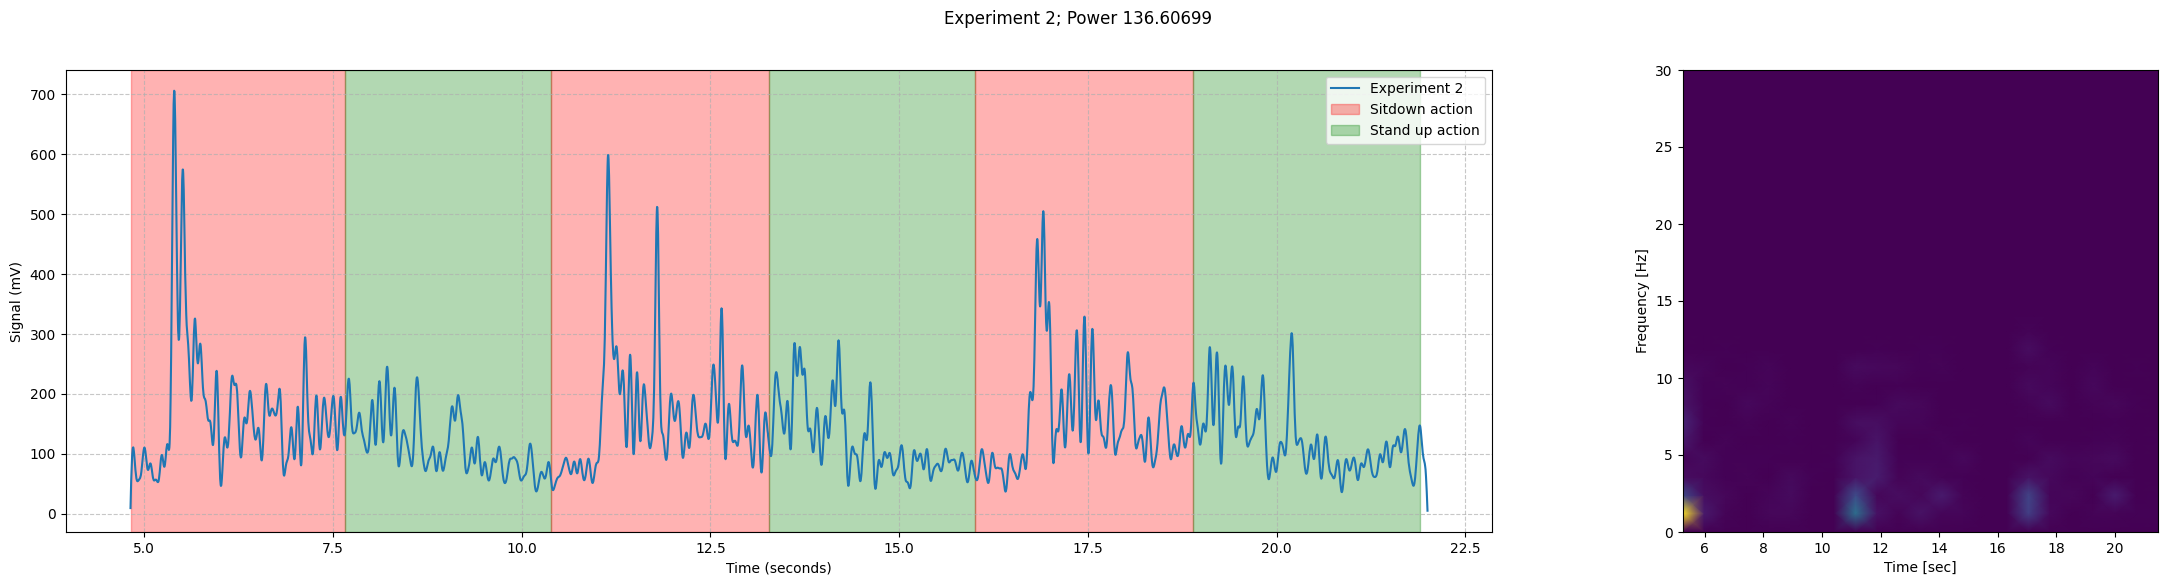

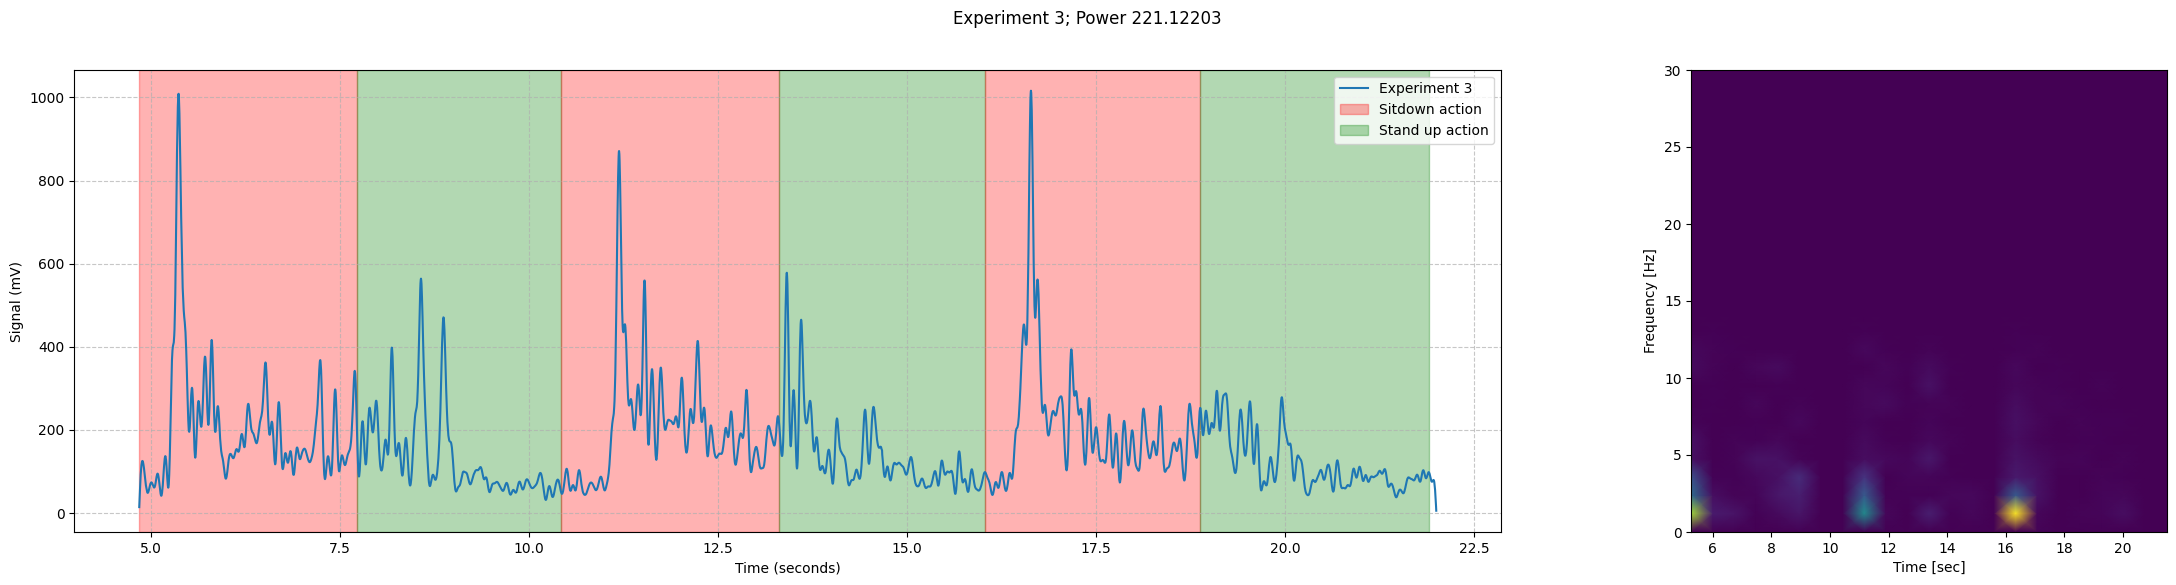

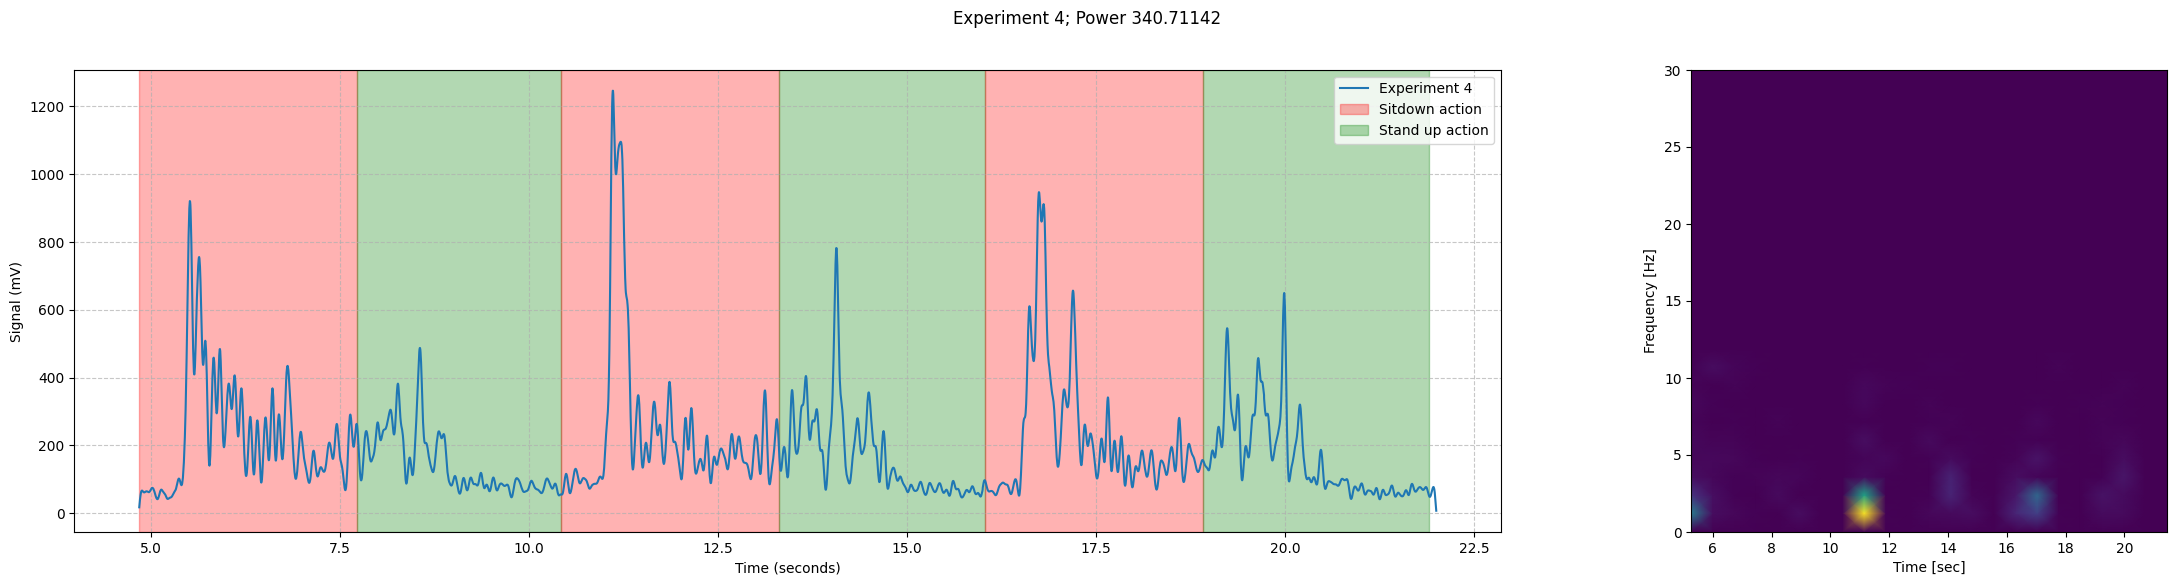

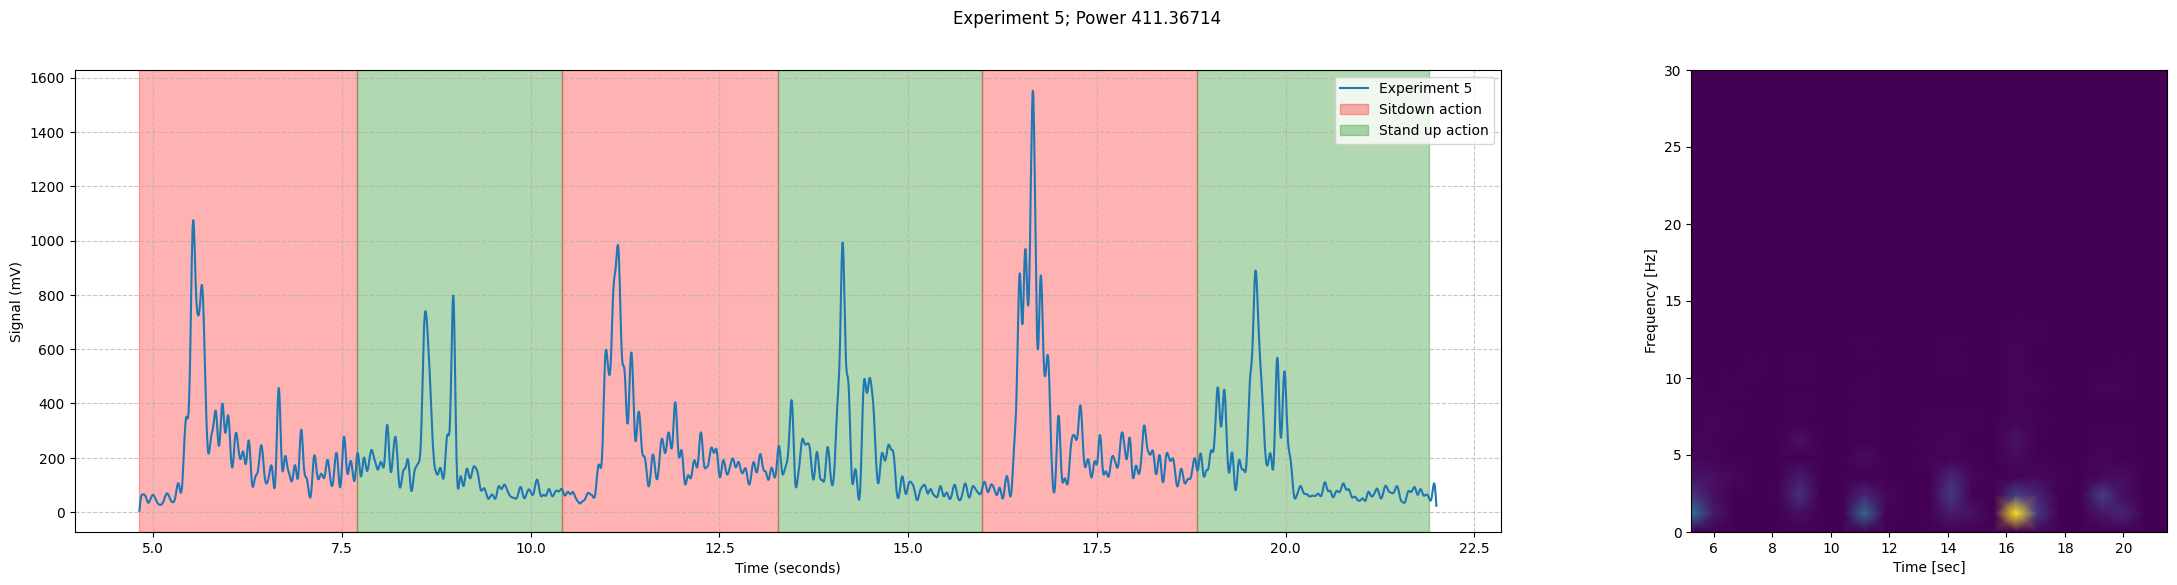

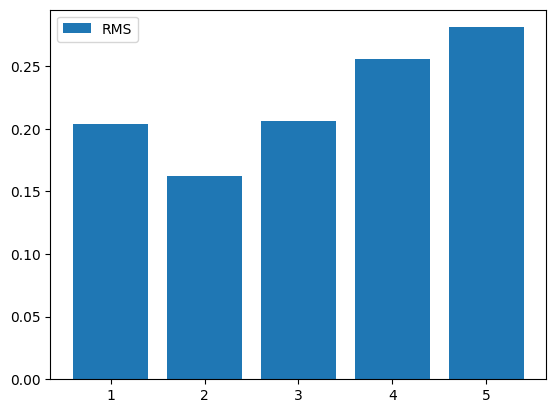

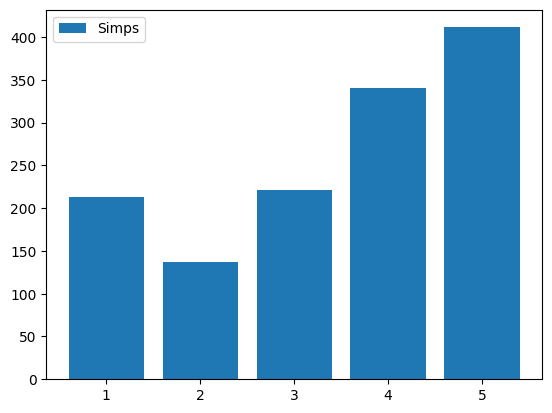

In [11]:
analyze_data("../data/rest_time/10min", 5, 0, show=True)